### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, classification_report
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from pdpbox import pdp, info_plots
from IPython.display import display
from sklearn.base import clone
from tabulate import tabulate
import shap

### Import Data

In [36]:
file_path = "https://raw.githubusercontent.com/sarahvastani/newrepo/refs/heads/main/rf_raw%20-%20motusSurvivalPhenotypes.20241203.csv"
df = pd.read_csv(file_path)
df = df.drop(df.columns[0], axis=1)
df.head()

,sex_binary,aims_ancestry,aims_heterozygosity,tarsus.length,tail.length,wing.cord,kipps,distal,p10,bodyCondition,releaseDay,fall_detectDay1,fall_bearing1,t5_spring40
0,1,0.136428,0.186393,28.7,71.0,99.0,29.6,NaN,NaN,1.306620,228,NaN,NaN,0
1,1,0.422082,0.620545,28.5,69.0,100.0,32.7,NaN,NaN,1.203509,229,250.0,130.888594,0
2,1,0.509015,0.707351,27.4,66.0,95.0,30.1,NaN,NaN,1.010949,233,260.0,174.492173,0
3,1,0.289157,0.447909,28.0,68.0,99.0,30.7,NaN,NaN,1.142857,233,NaN,NaN,0
4,1,0.383090,0.170494,29.8,67.0,96.0,29.7,NaN,NaN,0.979866,233,262.0,189.398267,0


### KNN Imputation

In [37]:
n_neighbors = 5 
knn_imputer = KNNImputer(n_neighbors=n_neighbors)
df = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns)
df.isna().sum()

sex_binary             0
aims_ancestry          0
aims_heterozygosity    0
tarsus.length          0
tail.length            0
wing.cord              0
kipps                  0
distal                 0
p10                    0
bodyCondition          0
releaseDay             0
fall_detectDay1        0
fall_bearing1          0
t5_spring40            0
dtype: int64

In [38]:
df.head()

,sex_binary,aims_ancestry,aims_heterozygosity,tarsus.length,tail.length,wing.cord,kipps,distal,p10,bodyCondition,releaseDay,fall_detectDay1,fall_bearing1,t5_spring40
0,1.0,0.136428,0.186393,28.7,71.0,99.0,29.6,60.52,16.0,1.306620,228.0,255.2,161.451001,0.0
1,1.0,0.422082,0.620545,28.5,69.0,100.0,32.7,61.04,15.6,1.203509,229.0,250.0,130.888594,0.0
2,1.0,0.509015,0.707351,27.4,66.0,95.0,30.1,58.30,16.2,1.010949,233.0,260.0,174.492173,0.0
3,1.0,0.289157,0.447909,28.0,68.0,99.0,30.7,60.64,15.8,1.142857,233.0,255.6,155.082488,0.0
4,1.0,0.383090,0.170494,29.8,67.0,96.0,29.7,58.16,16.2,0.979866,233.0,262.0,189.398267,0.0


### Set up feature columns (X) and target variable (y)

In [39]:
features = ['fall_detectDay1', 'fall_bearing1',
            'distal', 'p10', 'bodyCondition', 'tarsus.length',
            'kipps', 'tail.length', 'wing.cord', 
            'sex_binary', 'releaseDay', 'aims_heterozygosity', 
            'aims_ancestry']

X = df[features]
y = df['t5_spring40']
y = y.astype(int) 

#in the previous one, we included weight and p9, which is why the feature importances were different

#features = ['sex_binary','aims_ancestry','aims_heterozygosity','norm_tarsus.length',
#            'norm_weight','norm_tail.length', 'norm_wing.cord', 'norm_kipps', 'norm_distal', 
#            'norm_p9', 'norm_p10','norm_releaseDay','norm_fall_detectDay1','norm_fall_bearing1',
#           'norm_bodyCondition']

In [40]:
X.head()

,fall_detectDay1,fall_bearing1,distal,p10,bodyCondition,tarsus.length,kipps,tail.length,wing.cord,sex_binary,releaseDay,aims_heterozygosity,aims_ancestry
0,255.2,161.451001,60.52,16.0,1.306620,28.7,29.6,71.0,99.0,1.0,228.0,0.186393,0.136428
1,250.0,130.888594,61.04,15.6,1.203509,28.5,32.7,69.0,100.0,1.0,229.0,0.620545,0.422082
2,260.0,174.492173,58.30,16.2,1.010949,27.4,30.1,66.0,95.0,1.0,233.0,0.707351,0.509015
3,255.6,155.082488,60.64,15.8,1.142857,28.0,30.7,68.0,99.0,1.0,233.0,0.447909,0.289157
4,262.0,189.398267,58.16,16.2,0.979866,29.8,29.7,67.0,96.0,1.0,233.0,0.170494,0.383090


In [41]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: t5_spring40, dtype: int64

### SMOTE (Synthetic Minority Over-sampling Technique)

In [42]:
smote = SMOTE(random_state=1)

X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1)

model = RandomForestClassifier(class_weight='balanced', random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### Hyperparameter tuning

In [46]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  
    'bootstrap': [True, False]
}


grid_search = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced', random_state=1), 
                           param_grid=param_grid, 
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           error_score='raise')  

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       111
           1       0.90      0.77      0.83       106

    accuracy                           0.85       217
   macro avg       0.86      0.85      0.85       217
weighted avg       0.85      0.85      0.85       217



### Updated model

In [47]:
model = RandomForestClassifier(
    bootstrap=True, 
    max_depth=None, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=2, 
    n_estimators=200, 
    random_state=1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.847926267281106
Precision: 0.9010989010989011
Recall: 0.7735849056603774
F1 Score: 0.8324873096446702

Confusion Matrix:
 [[102   9]
 [ 24  82]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86       111
           1       0.90      0.77      0.83       106

    accuracy                           0.85       217
   macro avg       0.86      0.85      0.85       217
weighted avg       0.85      0.85      0.85       217



### Confusion matrix

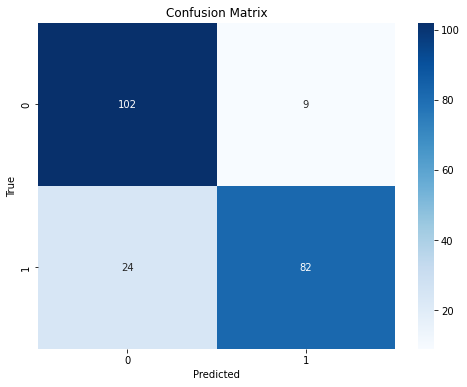

In [48]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Feature importance

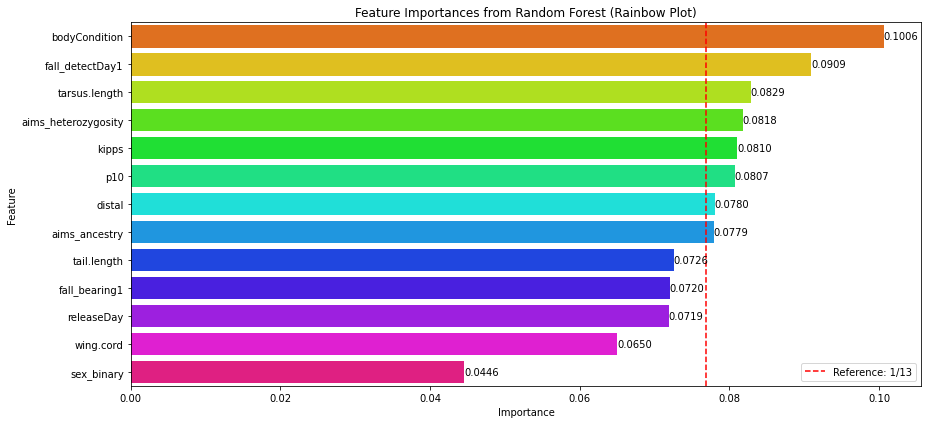

                Feature  Importance
4         bodyCondition    0.100629
0       fall_detectDay1    0.090942
5         tarsus.length    0.082874
11  aims_heterozygosity    0.081773
6                 kipps    0.081025
3                   p10    0.080730
2                distal    0.078037
12        aims_ancestry    0.077926
7           tail.length    0.072576
1         fall_bearing1    0.072024
10           releaseDay    0.071868
8             wing.cord    0.065004
9            sex_binary    0.044593


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_rainbow_feature_importance(model, features, seed=1):
    np.random.seed(seed)
    
    # Extract feature importances
    importances = model.feature_importances_

    feature_importances = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })

    # Sort features by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Calculate the number of features and reference line value
    num_features = feature_importances.shape[0]
    reference_line = 1 / num_features  # Vertical line at 1/# of features

    # Generate rainbow colors
    colors = sns.color_palette("hsv", num_features)

    # Plot the feature importances
    plt.figure(figsize=(13, 6))
    ax = sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_importances, 
        palette=colors
    )
    plt.title('Feature Importances from Random Forest (Rainbow Plot)')

    # Add vertical line at 1/# of features
    plt.axvline(x=reference_line, color='red', linestyle='--', label=f'Reference: 1/{num_features:.0f}')
    
    # Add the legend at the bottom-right
    plt.legend(loc='lower right')

    # Add text labels for feature importances
    for index, value in enumerate(feature_importances['Importance']):
        ax.text(value, index, f'{value:.4f}', va='center', color='black')

    plt.tight_layout()
    plt.show()

    return feature_importances

# Example usage
rainbow_feature_importance_df = plot_rainbow_feature_importance(model, features, seed=1)
print(rainbow_feature_importance_df)



### Histograms

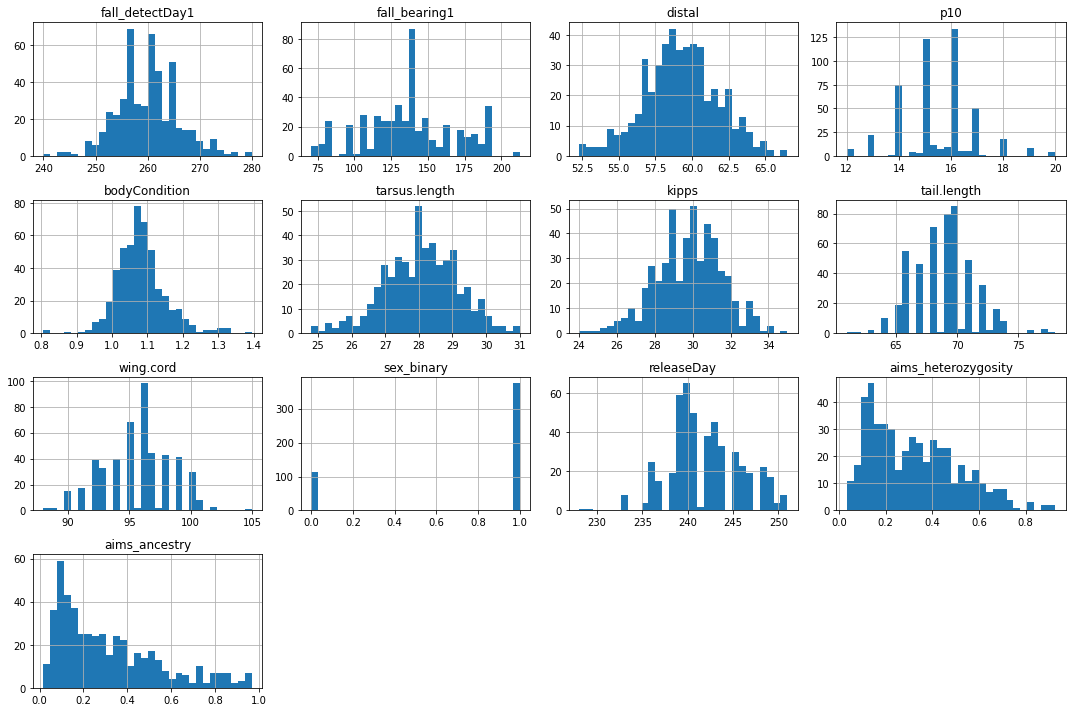

In [16]:
df[features].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

### Interaction Importance

In [53]:
def compute_interaction_importance(model, X, y, features, random_state=1):
    # Set a random state for reproducibility in model cloning
    interaction_importance = pd.DataFrame(columns=['feature_1', 'feature_2', 'importance'])
    
    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            X_interaction = X.copy()
            
            interaction_feature = X_interaction[features[i]] * X_interaction[features[j]]
            X_interaction[features[i] + '_x_' + features[j]] = interaction_feature
            
            model_clone = clone(model)
            model_clone.set_params(random_state=random_state)
            
            model_clone.fit(X_interaction, y)
            
            importances = model_clone.feature_importances_
            importance_value = importances[-1]
            
            new_row = pd.DataFrame({
                'feature_1': [features[i]],
                'feature_2': [features[j]],
                'importance': [importance_value]
            })
            interaction_importance = pd.concat([interaction_importance, new_row], ignore_index=True)
    
    total_importance = interaction_importance['importance'].sum()
    interaction_importance['importance'] = interaction_importance['importance'] / total_importance if total_importance > 0 else 0
    
    return interaction_importance.sort_values(by='importance', ascending=False)

interaction_importance_df = compute_interaction_importance(model, X_train, y_train, features, random_state=1)
print(tabulate(interaction_importance_df, headers='keys', tablefmt='pretty', showindex=False))

+---------------------+---------------------+----------------------+
|      feature_1      |      feature_2      |      importance      |
+---------------------+---------------------+----------------------+
|   fall_detectDay1   |    bodyCondition    | 0.017129995478731553 |
|    bodyCondition    |     releaseDay      | 0.015902966915991194 |
|    fall_bearing1    |     tail.length     | 0.015377773739380218 |
|   fall_detectDay1   |         p10         | 0.015249347110764058 |
|   fall_detectDay1   |     sex_binary      | 0.014993221786683091 |
|    fall_bearing1    |       distal        | 0.01497558365988115  |
|        kipps        |     sex_binary      | 0.014937325966028968 |
|    fall_bearing1    |      wing.cord      | 0.014861068306157856 |
|    fall_bearing1    |        kipps        | 0.014791288973696455 |
|       distal        |         p10         | 0.014617016707538214 |
|       distal        |    bodyCondition    | 0.014488684156192769 |
|   fall_detectDay1   |    fall_be

In [54]:
interaction_importance_df.to_csv('rf_new_raw_interaction_importance_unnnorm.csv', index=False)

### SHAP

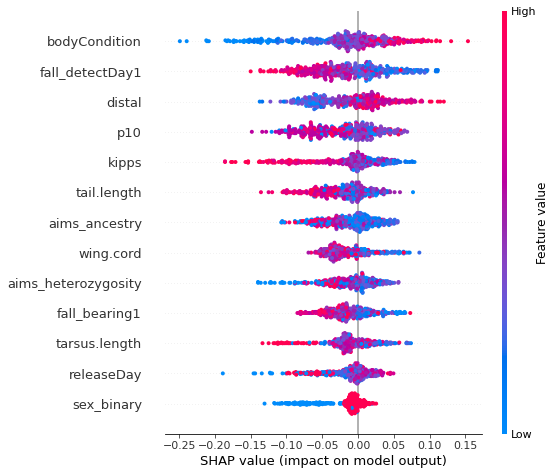

In [51]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X)[1]

shap.summary_plot(shap_values, X)

### SHAP dependence plots

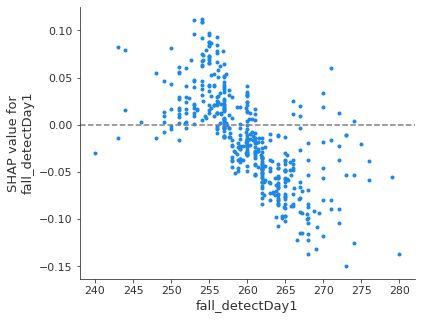

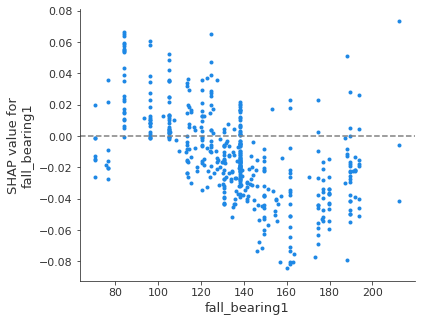

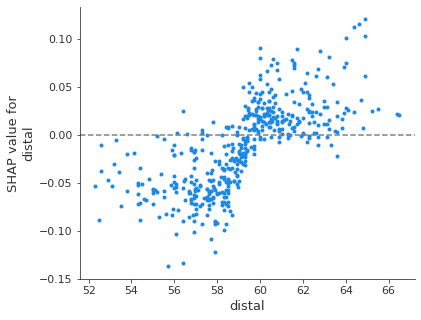

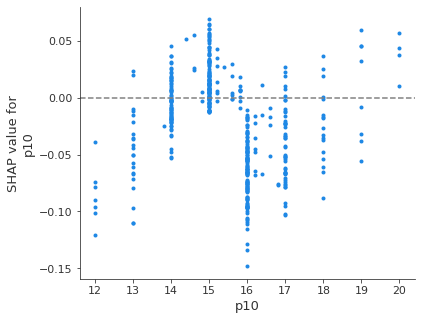

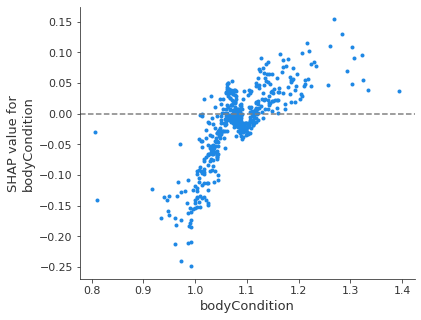

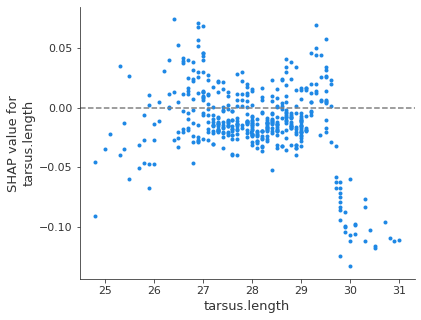

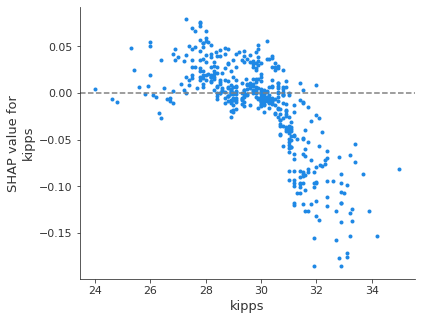

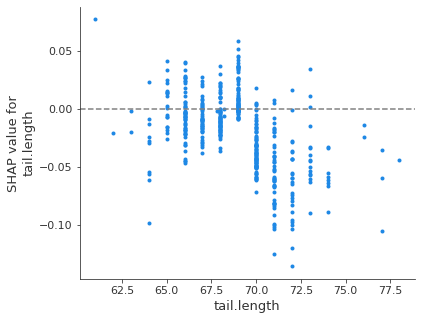

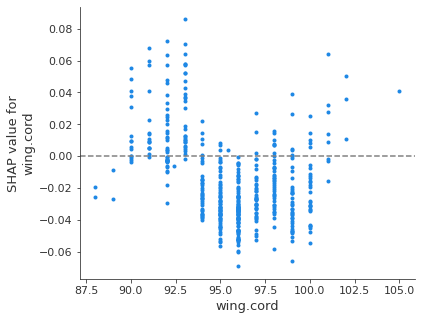

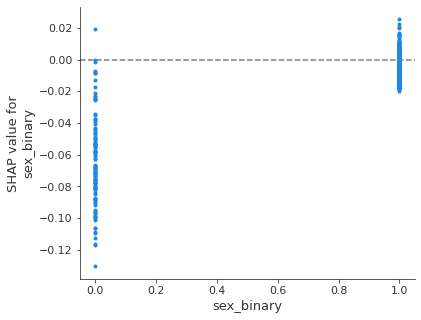

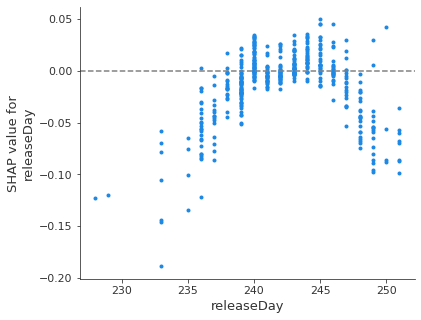

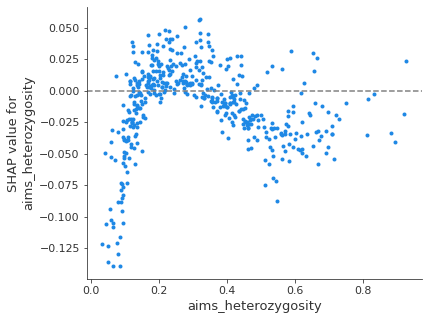

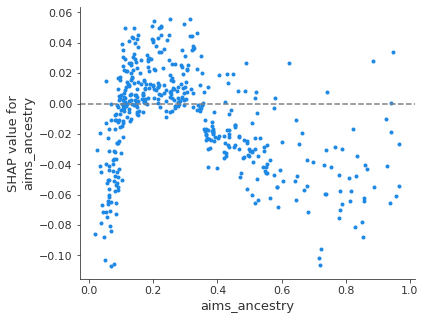

In [52]:
for feature in features:
    shap.dependence_plot(feature, shap_values, X, interaction_index=None, show=False) 
    
    plt.axhline(y=0, color='gray', linestyle='--')  
    
    plt.show()